# TTT4185 Machine learning for Speech technology

## Computer assigment 3a: Classification using Deep Neural Networks

This assignment assumes that the student has reviewed the material on deep neural networks.

In this assignment we will use the high level `Keras` framework together with `Tensorflow` to perform some deep learning experiments.

We will be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

The first few cells of this notebook contain example code to load and extract data, setup a simple network and train a deep neural network for classification. 

Note that we do not have a test dataset, but only training and validation sets. We do some experiments on the training set and observe the effect on the validation set.

In [3]:
import sys

print(sys.executable)

C:\ProgramData\Miniconda3\envs\tf_3.7\python.exe


In [4]:
!pip install -U scikit-learn

In [5]:
!pip install tensorflow


  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.


In [6]:
!pip install pandas


  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)


In [7]:
!pip install keras

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [10]:
# Load data from CSV files 
rawtrain = pd.read_csv("Train.csv")
rawvalid = pd.read_csv("Validation.csv")

# Take a peek at the raw data
rawtrain.head(10)

,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4
0,cjf0,F,h#,0.701982,2.125440,2.433528,3.530050,0.264459,0.326273,0.300301,0.410096
1,cjf0,F,q,0.340942,2.594934,2.788244,4.028250,0.282159,0.471724,0.310578,0.505835
2,cjf0,F,iy,0.487078,2.605132,3.093409,4.354061,0.174520,0.340025,0.232818,0.413965
3,cjf0,F,v,0.505536,2.034326,2.804329,4.130655,0.190478,0.307295,0.301741,0.370238
4,cjf0,F,ih,0.524527,2.055382,2.989248,4.480000,0.164466,0.312337,0.301859,0.362134
5,cjf0,F,n,0.601591,2.046562,3.251497,4.561420,0.185757,0.334235,0.316704,0.381524
6,cjf0,F,eh,0.762154,2.127740,3.212496,4.412842,0.207840,0.303633,0.285026,0.384152
7,cjf0,F,n,0.714553,1.837149,3.218620,5.001730,0.252105,0.311876,0.333318,0.432281
8,cjf0,F,q,0.619766,2.276717,3.109751,4.658425,0.231525,0.314789,0.406002,0.417538
9,cjf0,F,ix,0.463761,2.181577,2.859900,4.327639,0.170244,0.319690,0.291556,0.425367


In [11]:
# We will be classifying three different vowels. Extract the training and validation data
phonemes = ["ae", "ey", "ux"]
train = rawtrain[rawtrain["Phoneme"].isin(phonemes)]
valid = rawvalid[rawvalid["Phoneme"].isin(phonemes)]
trainlabels = [phonemes.index(ph) for ph in train["Phoneme"]]
validlabels = [phonemes.index(ph) for ph in valid["Phoneme"]]

In [12]:
# Features to use
features_F1toF2 = ["F1","F2"]

In [44]:
class PhonemesDataset:
    # initilize model based on given features
    def __init__(self, features, name='model'):
        self.name = name
        # Extract features
        x_train_raw = train[features]
        x_valid_raw = valid[features]

        # Normalize to zero mean
        x_mean = np.mean(x_train_raw)
        x_std = np.std(x_train_raw)
        self.x_train = x_train_raw - x_mean
        self.x_valid = x_valid_raw - x_mean

        # Fix labels. The "to_categorical" call maps integer labels {n}
        # to a vector of length N (number of labels) with a one in position n
        self.y_train = keras.utils.to_categorical(trainlabels, len(phonemes))
        self.y_valid = keras.utils.to_categorical(validlabels, len(phonemes))

    # Create a model with a single hidden layer
    def Create_and_train_SHL_model(self):
        self.model = keras.Sequential([
            keras.layers.Dense(256, activation=tf.nn.relu,
                               input_dim=self.x_train.shape[1]),
            keras.layers.Dense(len(phonemes), activation=tf.nn.softmax)
        ])

        self.model.summary()

        # Train the model
        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

        # Train the model
        self.history = self.model.fit(self.x_train, self.y_train, validation_data=(self.x_valid, self.y_valid),
                                      epochs=1000, batch_size=32, verbose=True)
        self.model.save('models/model_'+self.name)

    # Visualize the training results
    def Visualize(self):
        if (keras.models.load_model('models/model_'+self.name)):
            plt.figure(figsize=(10, 8))
            plt.plot(self.history.history['loss'], label='loss')
            plt.plot(self.history.history['accuracy'], label='acc')
            plt.plot(self.history.history['val_loss'], label='val_loss')
            plt.plot(self.history.history['val_accuracy'], label='val_acc')
            plt.grid()
            plt.title(self.name)
            plt.legend()
            plt.show()
        else:
            print("No model intilized")

    def Validate(self):
        # Validation model
        score = self.model.evaluate(self.x_valid, self.y_valid, verbose=0)
        print('Validation loss:', score[0])
        print('Validation accuracy:', score[1])

dataset_F1toF2 = PhonemesDataset(features_F1toF2, "F1toF2")


In [51]:
def Validate(dataset):
        # Validation model
        score = dataset.model.evaluate(dataset.x_valid, dataset.y_valid, verbose=0)
        print('Validation loss:', score[0])
        print('Validation accuracy:', score[1])

In [45]:
dataset_F1toF2.test = 2

In [46]:
dataset_F1toF2.Create_and_train_SHL_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.0548 - accuracy: 0.6529 - val_loss: 1.0249 - val_accuracy: 0.6421
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9740 - accuracy: 0.6960 - val_loss: 0.9653 - val_accuracy: 0.6310
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9028 - accuracy: 0.6781 - val_loss: 0.9190 - val_accuracy: 0.6199
Epoch 4/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.8494 - accu

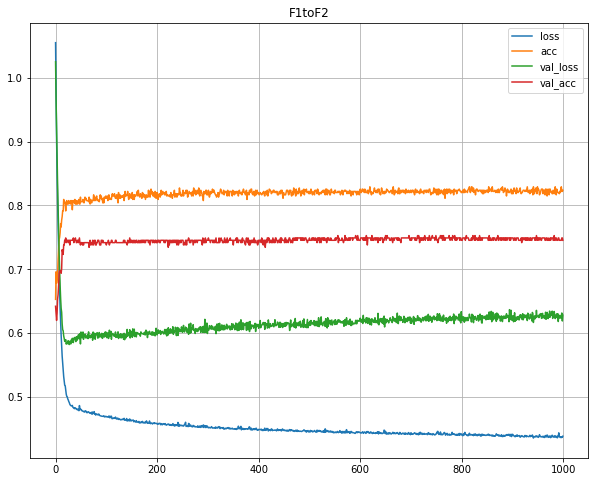

In [47]:
# Visualize the training results
dataset_F1toF2.Visualize()

In [48]:
# Validation model
score = dataset_F1toF2.model.evaluate(dataset_F1toF2.x_valid, dataset_F1toF2.y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.628196656703949
Validation accuracy: 0.7453874349594116


## Problem 1
Increase the number of features to include "F3" and "F4" and rerun the experiments. Try also adding the bandwidths ("B1"-"B4").

Initilize dataset

In [52]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

features_F1toF4 = ['F1', 'F2','F3','F4']

dataset_F1toF4 = PhonemesDataset(features_F1toF4, 'F1toF4')


Create model and train

In [53]:
# Create a model with a single hidden layer
dataset_F1toF4.Create_and_train_SHL_model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 771       
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 8ms/step - loss: 1.0517 - accuracy: 0.5486 - val_loss: 1.0402 - val_accuracy: 0.5129
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9737 - accuracy: 0.6061 - val_loss: 0.9968 - val_accuracy: 0.5387
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9169 - accuracy: 0.6259 - val_loss: 0.9614 - val_accuracy: 0.5498
Epoch 4/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.8668 - accur

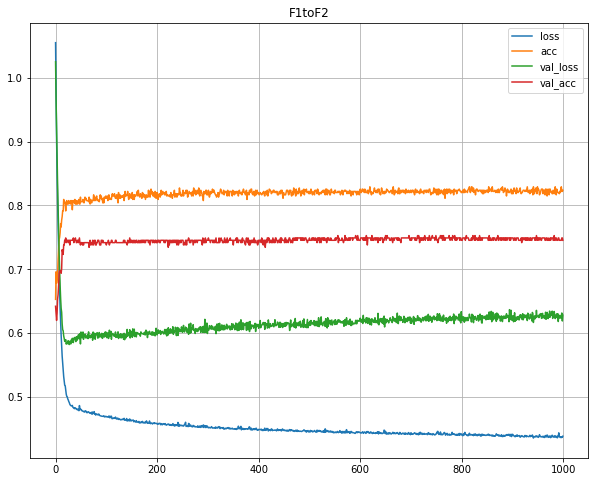

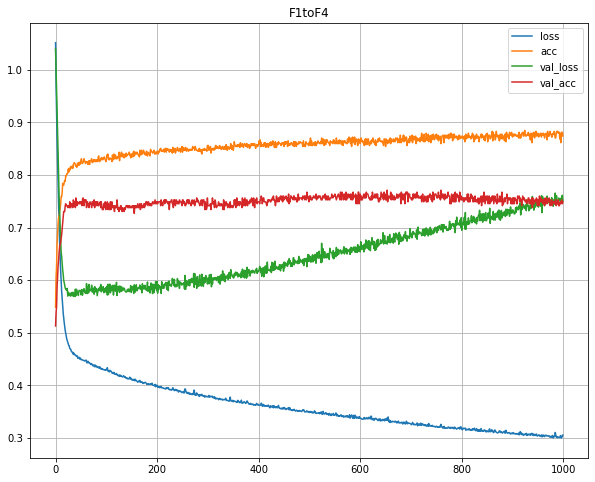

In [54]:
dataset_F1toF2.Visualize()
dataset_F1toF4.Visualize()

In [55]:
# Validation model
Validate(dataset_F1toF4)

Validation loss: 0.7499822974205017
Validation accuracy: 0.7490774989128113


#### B1 and B2

In [56]:
features_F1toF4_B1toB4 = ['F1', 'F2','F3','F4', 'B1', 'B2', 'B3', 'B4']

dataset_F1toF4_B1toB4 = PhonemesDataset(features_F1toF4_B1toB4, 'F1toF4_B1toB4')

In [57]:
# Create a model with a single hidden layer
dataset_F1toF4_B1toB4.Create_and_train_SHL_model()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               2304      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.0559 - accuracy: 0.5629 - val_loss: 1.0373 - val_accuracy: 0.5277
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.9788 - accuracy: 0.6097 - val_loss: 0.9921 - val_accuracy: 0.5351
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.9179 - accuracy: 0.6385 - val_loss: 0.9551 - val_accuracy: 0.5498
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.8679 - accu

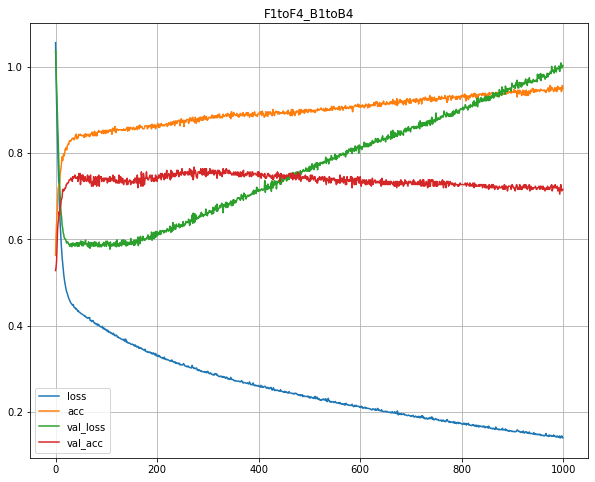

In [58]:
dataset_F1toF4_B1toB4.Visualize()

In [59]:
# Validation model
score = dataset_F1toF4_B1toB4.model.evaluate(dataset_F1toF4_B1toB4.x_valid, dataset_F1toF4_B1toB4.y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.0032891035079956
Validation accuracy: 0.7158671617507935


Comment: Seems to be overfitting

## Problem 2
Change the number of nodes in the hidden layer and see how the results change. Try using dropout, and observe the results.

In [60]:

# Create a model with a single hidden layer
def Create_and_train_SHL_model_512(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu,
                            input_dim=dataset.x_train.shape[1]),
        keras.layers.Dense(len(phonemes), activation=tf.nn.softmax)
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=1000, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)


Create_and_train_SHL_model_512(dataset_F1toF4)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 1539      
Total params: 4,099
Trainable params: 4,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 9ms/step - loss: 1.0334 - accuracy: 0.5917 - val_loss: 1.0139 - val_accuracy: 0.5203
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9360 - accuracy: 0.5989 - val_loss: 0.9688 - val_accuracy: 0.5277
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.8744 - accuracy: 0.6367 - val_loss: 0.9197 - val_accuracy: 0.5793
Epoch 4/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.8159 - accur

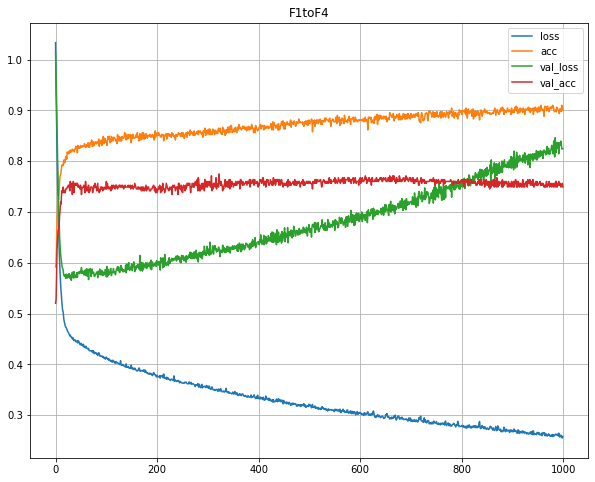

In [61]:
dataset_F1toF4.Visualize()

In [62]:
Validate(dataset_F1toF4)

Validation loss: 0.8245570063591003
Validation accuracy: 0.7490774989128113


#### with drop

In [63]:
# Create a model with a single hidden layer
def Create_and_train_SHL_model_512_dropout(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu,
                            input_dim=dataset.x_train.shape[1]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(phonemes), activation=tf.nn.softmax)
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=1000, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)

Create_and_train_SHL_model_512_dropout(dataset_F1toF4_B1toB4)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               4608      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 1539      
Total params: 6,147
Trainable params: 6,147
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.0514 - accuracy: 0.5629 - val_loss: 1.0301 - val_accuracy: 0.4945
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.9687 - accuracy: 0.5953 - val_loss: 0.9803 - val_accuracy: 0.5166
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.9045 - accuracy: 0.6

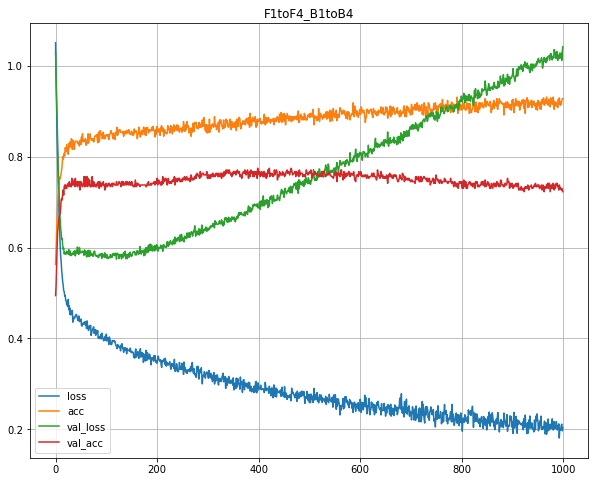

In [64]:
dataset_F1toF4_B1toB4.Visualize()

In [65]:
Validate(dataset_F1toF4)

Validation loss: 0.8245570063591003
Validation accuracy: 0.7490774989128113


In [66]:
Validate(dataset_F1toF4_B1toB4)

Validation loss: 1.042543888092041
Validation accuracy: 0.723247230052948


## Problem 3
Add multiple layers to the network and observe the results.

In [67]:
# Create a model with a multi hidden layer
def Create_and_train_MHL_model_256_dropout(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(256, activation=tf.nn.relu, input_dim=dataset.x_train.shape[1]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(len(phonemes), activation=tf.nn.softmax, name="pred", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),)
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=1000, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)

Create_and_train_MHL_model_256_dropout(dataset_F1toF4_B1toB4)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               2304      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                272       
_________________________________________________________________
pred (Dense)                 (None, 3)                 51        
Total params: 6,739
Trainable params: 6,739
Non-trainable params: 0
___________________________________________________

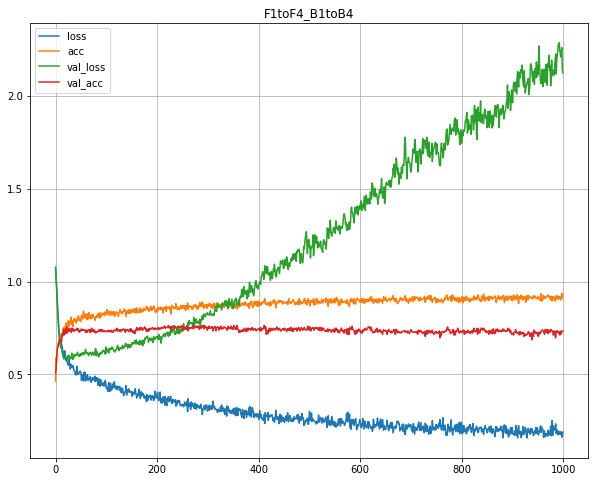

In [68]:
dataset_F1toF4_B1toB4.Visualize()

## Problem 4
Use the data to predict the gender of the speaker. Try including the format bandwidths as features as well ("B1"-"B4").

In [69]:
# We will be classifying gender. Extract the training and validation data

# train = rawtrain[rawtrain["Gender"].isin(Genders)]
# valid = rawvalid[rawvalid["Gender"].isin(Genders)]

genders = ["M", "F"]



In [70]:
train

,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4
39,cjf0,F,ae,0.714021,1.999640,2.834684,4.251902,0.162071,0.312755,0.331868,0.444793
83,daw0,F,ux,0.479160,2.019393,2.617239,4.230577,0.174437,0.280538,0.283287,0.356801
88,daw0,F,ux,0.460181,1.939525,2.671273,4.222328,0.180883,0.304328,0.320750,0.374378
107,daw0,F,ey,0.571166,2.015187,2.766610,4.231165,0.168104,0.292994,0.295626,0.375406
138,daw0,F,ey,0.590581,2.074329,2.808630,4.292247,0.203257,0.292376,0.294479,0.372362
...,...,...,...,...,...,...,...,...,...,...,...
12457,dlm0,M,ey,0.501317,1.912255,2.780398,3.809606,0.201844,0.307347,0.306120,0.369063
12476,dlm0,M,ae,0.522834,1.846401,2.517814,3.631916,0.214197,0.280197,0.340712,0.383663
12491,dlr0,M,ey,0.507001,1.856752,2.477168,3.441282,0.188706,0.278405,0.322157,0.396682
12551,dlr0,M,ey,0.547231,1.703629,2.492802,3.614419,0.191161,0.281738,0.349967,0.410256


In [71]:
class GenderModel:
    # initilize model based on given features
    def __init__(self, class_specifier, classes, features, name='model'):
        self.name = name
        self.classes = classes
        
        trainlabels = [genders.index(g) for g in rawtrain[class_specifier]]
        validlabels = [genders.index(g) for g in rawvalid[class_specifier]]

        # Extract features
        x_train_extracted = train[features]
        x_valid_extracted = valid[features]

        # Normalize to zero mean
        x_mean = np.mean(x_train_extracted)
        x_std = np.std(x_train_extracted)
        self.x_train = x_train_extracted - x_mean
        self.x_valid = x_valid_extracted - x_mean
        
        # Fix labels. The "to_categorical" call maps integer labels {n}
        # to a vector of length N (number of labels) with a one in position n
        self.y_train = keras.utils.to_categorical(trainlabels, len(classes))
        self.y_valid = keras.utils.to_categorical(validlabels, len(classes))

    # Visualize the training results
    def Visualize(self):
        if (self.history):
            plt.figure(figsize=(10, 8))
            plt.plot(self.history.history['loss'], label='loss')
            plt.plot(self.history.history['accuracy'], label='acc')
            plt.plot(self.history.history['val_loss'], label='val_loss')
            plt.plot(self.history.history['val_accuracy'], label='val_acc')
            plt.grid()
            plt.title(self.name)
            plt.legend()
            plt.show()
        else:
            print("No model intilized")

    def Validate(self):
        # Validation model
        score = self.model.evaluate(self.x_valid, self.y_valid, verbose=0)
        print('Validation loss:', score[0])
        print('Validation accuracy:', score[1])


gender_dataset_F1toF4_B1toB4 = GenderModel('Gender', genders, features_F1toF4_B1toB4, "gender_F1toF4_B1toB4")

In [72]:
gender_dataset_F1toF4_B1toB4.y_train.shape

(12591, 2)

In [73]:
# Create a model with a multi hidden layer
def Create_and_train_model(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(256, activation=tf.nn.relu, input_dim=dataset.x_train.shape[1]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(len(dataset.classes), activation=tf.nn.softmax, name="pred", kernel_regularizer=keras.regularizers.l1(1e-5))
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=100, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)

Create_and_train_model(gender_dataset_F1toF4_B1toB4)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               2304      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
pred (Dense)                 (None, 2)                 130       
Total params: 18,882
Trainable params: 18,882
Non-trainable params: 0
_________________________________________________________________


ValueError: Data cardinality is ambiguous:
  x sizes: 556
  y sizes: 12591
Please provide data which shares the same first dimension.

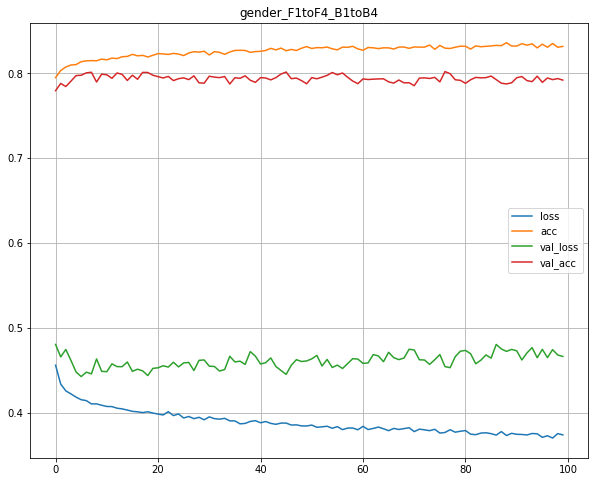

In [ ]:
gender_dataset_F1toF4_B1toB4.Visualize()

In [ ]:
gender_dataset_F1toF4_B1toB4.Validate()

Validation loss: 0.46635711193084717
Validation accuracy: 0.7919058799743652
